In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import truncnorm
import pickle
import flexcode
from flexcode.regression_models import NN, RandomForest 

import matplotlib.pyplot as plt

import local_conformal as lc

In [2]:
x, y = lc.generate_data_b0(10000)

In [3]:
df = pd.DataFrame(data = {"x":x, "y":y})

In [4]:
import plotnine as p9

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


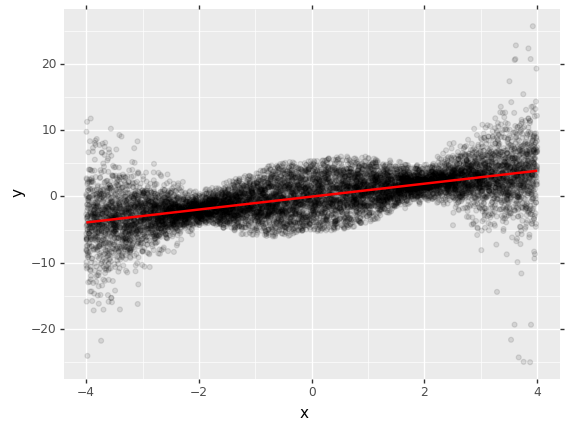

<ggplot: (8778032289053)>

In [6]:
p9.ggplot(df) +\
    p9.geom_point(p9.aes(x="x",y="y"),
                 alpha = .1) +\
    p9.geom_smooth(p9.aes(x="x",y="y"), color = "red")

# What will our MDN Perceptron look like?



x (1d) -> hidden layer sqrt(n) * or tune? -> $(\pi, \mu, \sigma)_k$

tuning: 
1. \# of gaussians: $k$ ($1 \to \sqrt{n}$)
2. size of hidden layer: $\sqrt{n} \to n$

We will also loop through number of observations ($100 \to 10,000$)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class MDNPerceptrion(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        """
        create a single hidden layer MDN Perceptrion for a 1D input (output is 
        also in 1D space).
        
        Args:
        -----
        n_hidden: int, number of nodes in hidden layer
        n_guassians: int, number of gaussians in final output layer
        """
        nn.Module.__init__(self)
        self.n_guassians = n_gaussians
        self.n_hidden = n_hidden
        
        self.fc = nn.Linear(1, n_hidden)
                
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x):
        """
        Returns parameters of for a mixture of gaussians given x
        
        Args:
        -----
        x: data x value (single scalar)
        
        Returns:
        --------
        mu: vector of means of the gaussians
        sigma: vector representing the diagonals of the covariances of the 
            gaussians
        pi: probability distribution over the gaussians
        """
        x = self.fc(x)
        hidden = F.relu(x)
        
        pi = F.softmax(self.z_pi(hidden), 1) # to get probablity
        mu = self.z_mu(hidden)
        sigma = torch.exp(self.z_sigma(hidden)) # to get positive

        return pi, mu, sigma
        
    def sample(self, mu, sigma, pi):
        """
        Makes a random draw from a randomly selected mixture based on parameters
        
        Args:
        -----
        mu: vector of means of the gaussians
        sigma: vector representing the diagonals of the covariances of the 
            gaussians
        pi: probability distribution over the gaussians
        """
        mixture = torch.normal(mu, sigma)
        k = torch.multinomial(pi, 1, replacement=True).squeeze()
        result = mixture[range(k.size(0)), k]
        return result
    
    def loss_fn(self, y, mu, sigma, pi):
        """
        Computes the log probability of the datapoint being drawn from all the 
        gaussians parametized by the network.
    
        
         Args:
        -----
        y: potential vector of y values
        mu: vector of means of the gaussians
        sigma: vector representing the diagonals of the covariances of the 
            gaussians
        pi: probability distribution over the gaussians
        
        Details / Notes:
        ----------------
        I'm slightly worried about the numerical stability given this is going
        back and forth between log() and exp().
        
        """
        
        mixture = torch.distributions.normal.Normal(mu, sigma)
        log_prob = mixture.log_prob(y.reshape(-1,1))
        prob = torch.exp(log_prob)
        weighted_prob = prob * pi
        inner_sum = torch.sum(weighted_prob, dim=1)
        log_prob_loss = -torch.log(inner_sum)
        ave_log_prob_loss = torch.mean(log_prob_loss)
        return ave_log_prob_loss

In [18]:
import progressbar


# data splitting

| | Training (and validate)|CDE-Tune|Calibrate|
|-|-|-|-|
|Izbicki| 2n|0|1n|
|Us| 1.5n|.75n|.75n|


# Tuning

In order to tune we'll need a `x/y_validation` dataset as well -  

We're already going to go through all the models - do we want model selection first? 


# Overall:

1. Us: estimate grouping models based on CDE-tune data
2. Grouping approaches (`profile_grouping` function can be used)
3. Testing: define grid along X space, sample 300 Y values, and then see the proportion contained at levels .95,.9,.8,.6

## data collection:

| sim index |`n` Size |Model Type | X value| expected confidence | actual attainment |
|-|-|-|-|-|-|
|1,...,20| 100, 316, 1000, 3162, 10000| MDNPerceptrion| range between -2,2 | .95,.9,.8,.6 | **???** |

### things to think about: I'm still a little uncertain 